In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [0]:
# разделим выборку
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],  # датасет из двух колонок (для визуализации дальше)
    wine.target,   # классы которые нужно предсказать
    test_size=0.3, 
    shuffle=True)

# Оборачивае выборкки в тензоры
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [0]:
# Нейросеть для классификации
class WineNet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super(WineNet, self).__init__()
    self.fc1 = torch.nn.Linear(2, n_hidden_neurons)    # 2 входа для каждой бутылки вина
    self.activ1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
    self.activ2 = torch.nn.Sigmoid()
    self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)  # 3 класса вин всего
    self.sm = torch.nn.Softmax(dim=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.activ1(x)
    x = self.fc2(x)
    x = self.activ2(x)
    x = self.fc3(x)
    # не выдаем тут self.sm(x) т.к. хотим еще посчитать кросс-энтропию
    # (в кросс-энтропии выходы нейроной сети прогоняются через логарифм но
    # в softMax есть экспоненты) -> взаимоуничтожаются, значит можем посчитать кросс-энтропию не считая softMax
    return x

  def inference(self, x):  # inference - вывод
    x = self.forward(x)
    x = self.sm(x)
    return x

wine_net = WineNet(5)

In [0]:
# функция потерь - бинарная кроссЭнтропия (использующая выхода не пропущенные черех softMax)
loss = torch.nn.CrossEntropyLoss()
# оптимизатор для градиентных шагов
optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

In [13]:
# функция которая выдает массив со значениями в случайном порядке до 5
np.random.permutation(5)

array([0, 4, 3, 2, 1])

In [14]:
# батчи
batch_size = 10

for epoch in range(5000):
  # порядок индексов для датасета
  order = np.random.permutation(len(X_train))  # перемешивает датасет дальше
  for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()
      # вычисляем подмножества размерам в батч - т.е каждую эпоху гарантировано проходим все данные
      batch_indexes = order[start_index:start_index+batch_size]
      # берем значения по батчам
      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]
      # пропусти весь батч через сетку (без софт-макса)
      preds = wine_net.forward(x_batch)
      # считаем Loss
      loss_val = loss(preds, y_batch)
      loss_val.backward()  #резльтаты окажутся в Optimizer
      optimizer.step()

      # каждые 100 эпох смотрим как обучеается сетка на тестовом датасете
      if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)  # смотрим какой выход до софт-макса был наибольшим - номер нейрона
        print((test_preds == y_test).float().mean())  # Доля совпадения (нейрон с макс выходом совпал с правильным классом)

tensor(0.3333)
tensor(0.3333)
tensor(0.3333)
tensor(0.3333)
tensor(0.3333)
tensor(0.3333)
tensor(0.3333)
tensor(0.3333)
tensor(0.3333)
tensor(0.3333)
tensor(0.3333)
tensor(0.3333)
tensor(0.3333)
tensor(0.5556)
tensor(0.5556)
tensor(0.5556)
tensor(0.5556)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.5185)
tensor(0.5185)
tensor(0.5185)
tensor(0.5185)
tensor(0.5185)
tensor(0.5185)
tensor(0.5185)
tensor(0.5185)
tensor(0.5185)
tensor(0.5185)
tensor(0.5185)
tensor(0.5185)
tensor(0.5185)
tensor(0.3148)
tensor(0.3148)
tensor(0.3148)
tensor(0.3148)
tensor(0.3148)
tensor(0.3148)
tensor(0.3148)
tensor(0.3148)
tensor(0.3148)
tensor(0.3148)
tensor(0.3148)
tensor(0.3148)
tensor(0.3148)
tensor(0.3704)
tensor(0.3704)
tensor(0.3704)
tensor(0.3704)
tensor(0.3704)
tensor(0.3704)
tensor(0.3704)
tensor(0.3704)
tensor(0.3704)
tensor(0.3704)
tensor(0.3704)
tensor(0.3704)
tensor(0.3704)
tensor(0.3889)
tensor(0.3

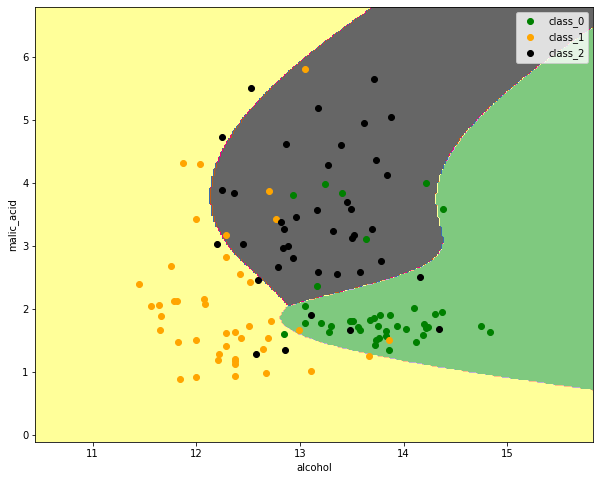

In [15]:
# ВИЗУАЛИЗАЦИЯ
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()
  